# Plot Figure 2

This notebook plots Figure 2 from the manuscript.

## Import Necessary Packages

In [5]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

## User-Defined Fields

In [6]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
REGIONS = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
CASES   = {
    'JJ':[(6,'June','#D42028'),(7,'July','#F2C85E')],
    'JA':[(7,'July','#F2C85E'),(8,'August','#5BA7DA')]}
SAMPLETHRESH = 50

## Import Binned Statistics Data

Open binned statistics netCDF file stored in ```FILEDIR```.

In [7]:
def load(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds.load()

In [8]:
loresstats = load('ERA5_GPCP_binned_stats.nc')
hiresstats = load('ERA5_IMERG_binned_stats.nc')

## Functions for Plotting

The ```get_bin_mean_pr()``` function calculates the mean precipitation in each bin, and ```get_pdf()``` calculates either the regular or precipitating (points where precipitation > ```PRTHRESH```) probability density function (PDF). Both functions only run calculations for bins with more samples than ```SAMPLETHRESH```, and can be run for two cases: the 1D case (for $B_L$ bins) or 2D case (for joint $\mathrm{CAPE_L}$-$\mathrm{SUBSAT_L}$ bins).

In [12]:
def get_bin_mean_pr(stats,bintype='1D',samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        coords = {'bl':stats.bl.values}
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
    if bintype=='2D':
        coords = {'subsat':stats.subsat.values,'cape':stats.cape.values}
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
    return xr.DataArray(binmeanpr,coords=coords)

def get_pdf(stats,bintype,precipitating,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        Q[Q<samplethresh] = np.nan
        pdf = Q/np.nansum(Q)
        return xr.DataArray(pdf,coords={'bl':stats.bl.values})
    elif bintype=='2D':
        P0  = stats.P0.values
        PE  = stats.PE.values
        P   = PE if precipitating else P0
        pdf = PE/(np.nansum(P0)*np.diff(stats.subsat.values)[0]*np.diff(stats.cape.values)[0])
        subsatmaxidx,capemaxidx = np.where(P==np.nanmax(P))
        subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return xr.DataArray(pdf,coords={'subsat':stats.subsat.values,'cape':stats.cape.values}),subsatmaxidx,capemaxidx

## Plot the Figure

Set the plotting kwargs, calculate the variables of interest, and plot them.

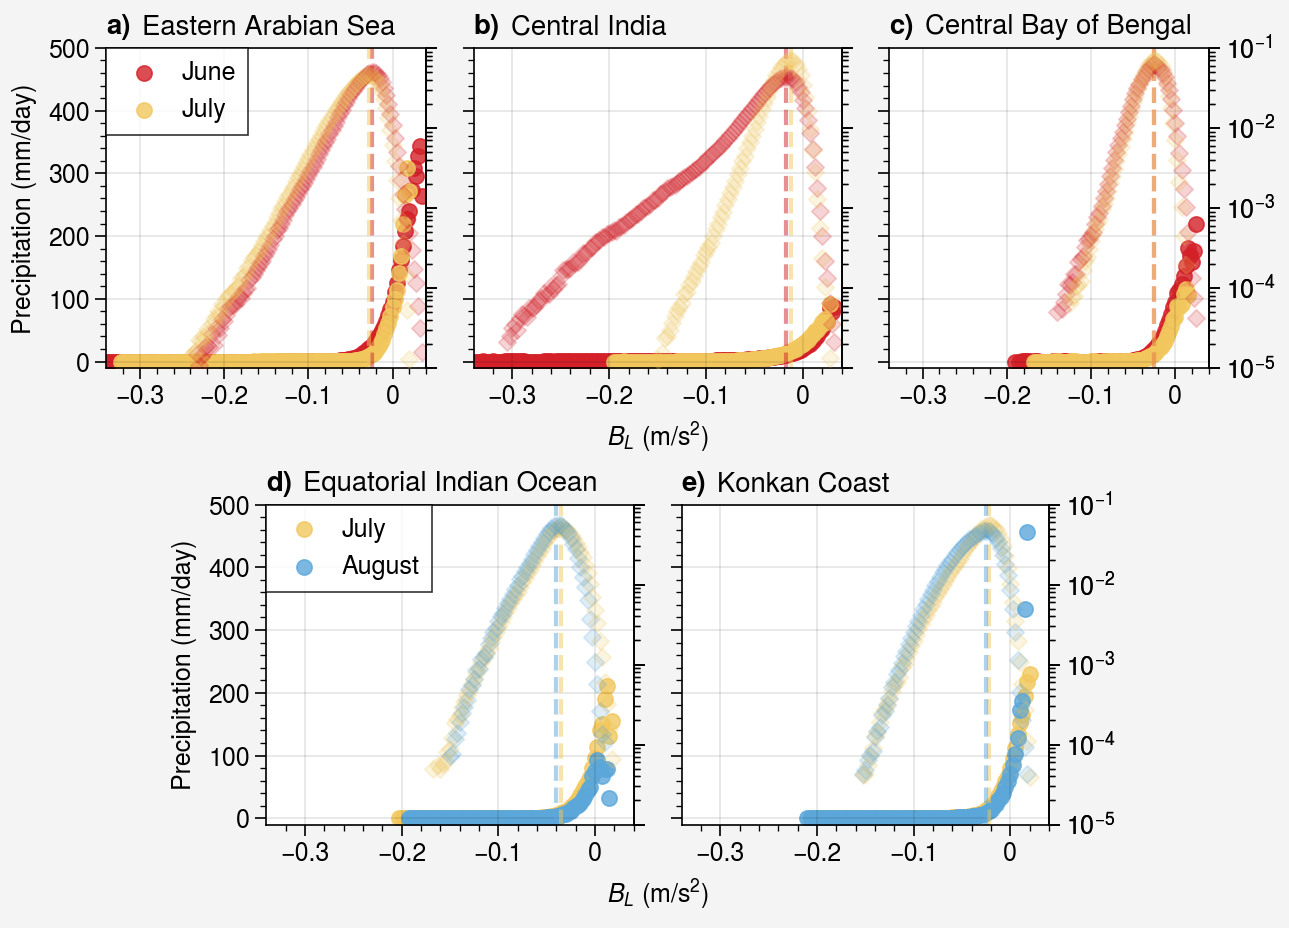

In [23]:
stats = hiresstats
prkwargs = dict(marker='o',alpha=0.8,s=30)
blkwargs = dict(marker='D',alpha=0.1,s=20)

fig = pplt.figure(refaspect=1, refwidth=1.6)
axs = fig.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]])
axs.format(abcloc='l', abc='a)', xlabel='$\mathit{B_L}$ (m/s$^2$)', xlim=(-0.34,0.04), xticks=0.1,
           ylabel='Precipitation (mm/day)', ylim=(-10,500), yticks=100)

for i, region in enumerate(stats.region.values):
    ax = axs[i]
    ax.format(titleloc='l', title=f'{region}')
    bx = ax.twinx()
    bx.format(yscale='log', yformatter='log', ylim=(10e-6,0.1))
    if i==0 or i==1 or i==3:
        bx.format(yticklabels=[])
    casekey = 'JJ' if i<3 else 'JA'
    axnum=0 if casekey=='JJ' else 3
    for month, label, color in CASES[casekey]:
        monthstats = stats.sel(region=region, month=month)
        blpdf = get_pdf(monthstats, bintype='1D', precipitating=True)
        binmeanpr = get_bin_mean_pr(monthstats, bintype='1D')
        
        modeidx = np.nanargmax(blpdf.values)
        mode = blpdf.bl.values[modeidx]
        
        bx.scatter(blpdf,color=color,**blkwargs)
        ax.scatter(binmeanpr,color=color,label=label,**prkwargs)
        ax.axvline(mode,color=color,linestyle='--',alpha=0.5)
        
    axs[axnum].legend(loc='ul',ncols=1)

pplt.show()
# fig.save(f'{SAVEDIR}/fig_2.png',dpi=900)

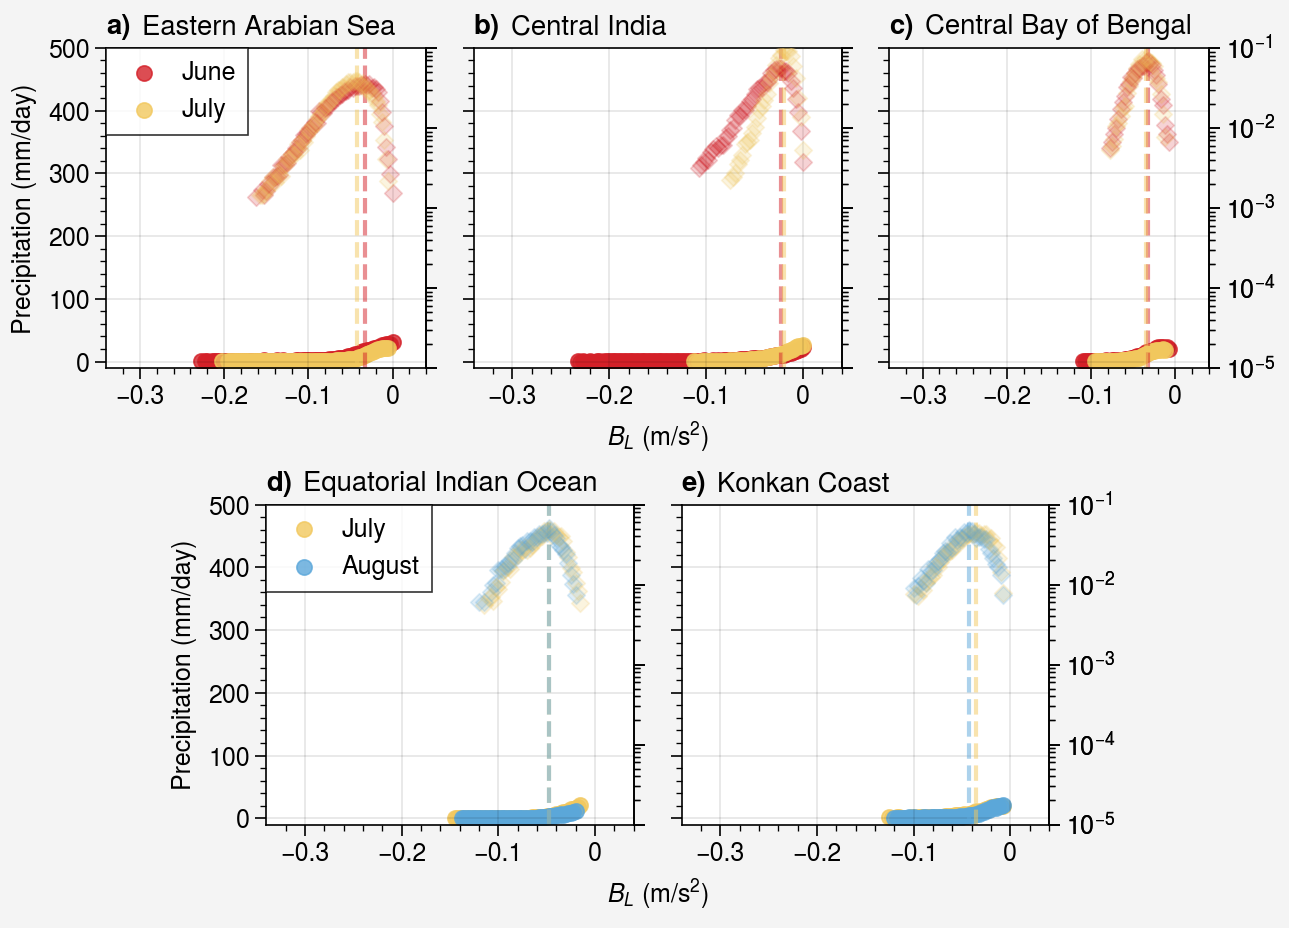

In [24]:
stats = loresstats
prkwargs = dict(marker='o',alpha=0.8,s=30)
blkwargs = dict(marker='D',alpha=0.1,s=20)

fig = pplt.figure(refaspect=1, refwidth=1.6)
axs = fig.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]])
axs.format(abcloc='l', abc='a)', xlabel='$\mathit{B_L}$ (m/s$^2$)', xlim=(-0.34,0.04), xticks=0.1,
           ylabel='Precipitation (mm/day)', ylim=(-10,500), yticks=100)

for i, region in enumerate(stats.region.values):
    ax = axs[i]
    ax.format(titleloc='l', title=f'{region}')
    bx = ax.twinx()
    bx.format(yscale='log', yformatter='log', ylim=(10e-6,0.1))
    if i==0 or i==1 or i==3:
        bx.format(yticklabels=[])
    casekey = 'JJ' if i<3 else 'JA'
    axnum=0 if casekey=='JJ' else 3
    for month, label, color in CASES[casekey]:
        monthstats = stats.sel(region=region, month=month)
        blpdf = get_pdf(monthstats, bintype='1D', precipitating=True)
        binmeanpr = get_bin_mean_pr(monthstats, bintype='1D')
        
        modeidx = np.nanargmax(blpdf.values)
        mode = blpdf.bl.values[modeidx]
        
        bx.scatter(blpdf,color=color,**blkwargs)
        ax.scatter(binmeanpr,color=color,label=label,**prkwargs)
        ax.axvline(mode,color=color,linestyle='--',alpha=0.5)
        
    axs[axnum].legend(loc='ul',ncols=1)

pplt.show()
# fig.save(f'{SAVEDIR}/fig_2.png',dpi=900)

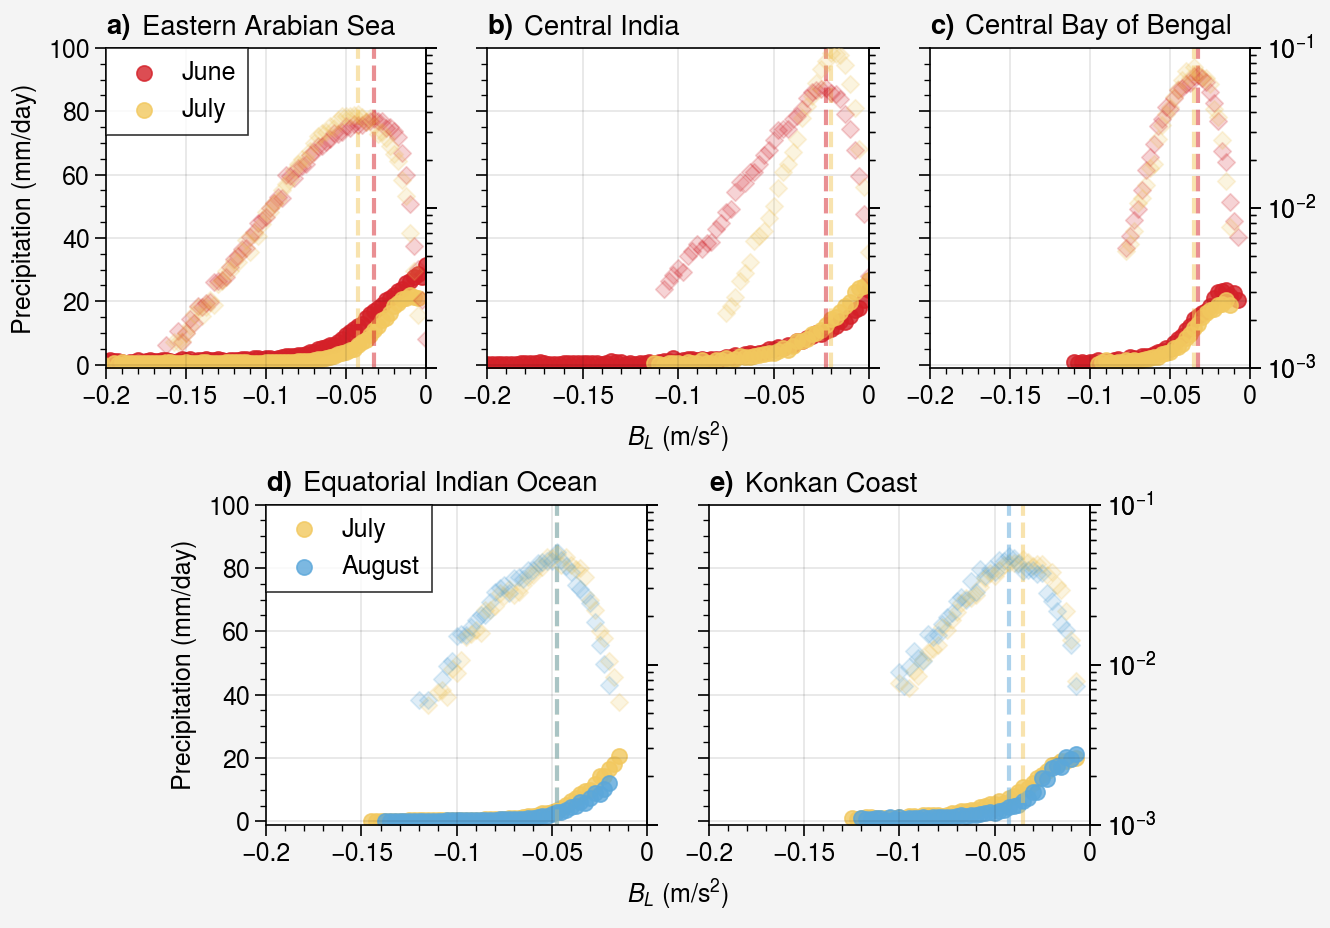

In [26]:
stats = loresstats
prkwargs = dict(marker='o',alpha=0.8,s=30)
blkwargs = dict(marker='D',alpha=0.1,s=20)

fig = pplt.figure(refaspect=1, refwidth=1.6)
axs = fig.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]])
axs.format(abcloc='l', abc='a)', xlabel='$\mathit{B_L}$ (m/s$^2$)', xlim=(-0.2,0.0), xticks=0.05,
           ylabel='Precipitation (mm/day)', ylim=(-1,100), yticks=20)

for i, region in enumerate(stats.region.values):
    ax = axs[i]
    ax.format(titleloc='l', title=f'{region}')
    bx = ax.twinx()
    bx.format(yscale='log', yformatter='log', ylim=(10e-4,0.1))
    if i==0 or i==1 or i==3:
        bx.format(yticklabels=[])
    casekey = 'JJ' if i<3 else 'JA'
    axnum=0 if casekey=='JJ' else 3
    for month, label, color in CASES[casekey]:
        monthstats = stats.sel(region=region, month=month)
        blpdf = get_pdf(monthstats, bintype='1D', precipitating=True)
        binmeanpr = get_bin_mean_pr(monthstats, bintype='1D')
        
        modeidx = np.nanargmax(blpdf.values)
        mode = blpdf.bl.values[modeidx]
        
        bx.scatter(blpdf,color=color,**blkwargs)
        ax.scatter(binmeanpr,color=color,label=label,**prkwargs)
        ax.axvline(mode,color=color,linestyle='--',alpha=0.5)
        
    axs[axnum].legend(loc='ul',ncols=1)

pplt.show()
# fig.save(f'{SAVEDIR}/fig_2.png',dpi=900)